Calculate the integrated gradients of each group base on the models
Will allow to print the sequences or export them gradients 

In [1]:
!pip install concise

     |████████████████████████████████| 1.3MB 5.1MB/s 
     |████████████████████████████████| 317kB 50.3MB/s 
  Created wheel for gtfparse: filename=gtfparse-1.2.0-cp36-none-any.whl size=11883 sha256=7d4f6ff04fef5704b573676728cb021d7b66254c68b9bc8a5323a08a13603ea8
  Stored in directory: /root/.cache/pip/wheels/c4/27/96/6ba6fe28cbb162c326823553e3e45ac502160d1340566360f8
Successfully built gtfparse
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [4]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import glob
import sys

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import utils
sys.path.append(".")
import plotseqlogo
import IntegratedGradients
from plotseqlogo import *
from IntegratedGradients import *
from utils import *
from interpretation_exp import *

from tensorflow.python.keras.backend import set_session

CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 

TensorFlow 1.x selected.


Using TensorFlow backend.
2020-08-03 11:58:03,723 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-08-03 11:58:03,745 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


2020-08-03 11:58:04,238 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/gdrive/My Drive/nn/plotseqlogo.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/gdrive/My Drive/nn/plotseqlogo.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public A

In [5]:
def predict(models, x, use_majority=True):
  """
  Predict the output of x using the different models that were provided, if use_majority=True we use majority vote, if False we use Average vote
  :param models: A list of loaded models 
  :param x: The dataset to predict on
  :param use_majority:if use_majority=True we use majority vote, if False we use Average vote
  :return the prediction for labels 
  """
  y_pred = np.zeros(shape=(x.shape[0], len(models)))
  
  for i in range(len(models)):
    if use_majority:
      model_prediciton = np.round(models[i].predict(x))    
    else:
      model_prediciton = models[i].predict(x)

    y_pred[:,i] = model_prediciton.reshape(model_prediciton.shape[0])
    
  return np.round(np.mean(y_pred, axis=1))

In [6]:
def get_refrence_mean_baseline(current_seq,mean_sequence):
  """
  Get a refrence sequence based on the mean sequences 
  :param: current_seq - The current sequence we are trying to create baseline to
  :param: mean_sequence - The mean value of all sequences
  """
  baseline = current_seq * mean_sequence 
  return baseline


def get_explanations(models, predict_label, rf_mean_sequence, x_sequences, y_labels, number_of_sequences_to_explain=-1, threshold =0.5):
  """
  Get explanations in format of integreated gradients for the different sequences
  :param models: The models to use to get the explanations
  :param predict_label: The label we should predict
  :param rf_mean_sequence: The refrence sequence based on mean of all sequences
  :param x_sequences: x dataset to explain
  :param y_labels: The labels of the dataset
  :param number_of_sequences_to_explain: Number of sequences to explain, -1 mean all
  :param threshold : threshold of prediction to consider this a good sequence 
  :return: The explanation using integrated gradients 
  """
  
  # Need to see if we can do without this 
  # sess = tf.Session()
  # tf.random.set_random_seed(5005)
  # K.set_session(sess)

  # session = K.get_session()
  init = tf.global_variables_initializer()
  # session.run(init)

  true_prediction_index= []
  # with session.as_default():
  #     with session:
  model_pred = predict(models, x_sequences)

  model_pred = 1 - model_pred if predict_label ==CLASS_PARTIAL_LOSS else model_pred

  for i in sorted(enumerate(model_pred), key=lambda x:x[1],reverse=True):
    if y_labels[i[0]]==predict_label and model_pred[i[0]] > threshold :
      true_prediction_index.append(i[0])
  
  if number_of_sequences_to_explain != -1:
    true_prediction_index = true_prediction_index[:number_of_sequences_to_explain]

  explanations = []
  for model in models:
    gradients = integrated_gradients(model) 
    model_explanation=np.array([gradients.explain([x_sequences[i]],reference=[get_refrence_mean_baseline(x_sequences[i], rf_mean_sequence)],num_steps=100)[0] for i in true_prediction_index])
    explanations.append(model_explanation)

  combined_explanation = np.array(explanations).mean(axis=0)

  if predict_label == CLASS_PARTIAL_LOSS:
    combined_explanation = combined_explanation * -1

  return combined_explanation

In [7]:
def get_explanation_for_data(models_folder, data_path, save_path=None, number_of_seq=-1, threshold=0.5):
  """
  Get an explanation in form of integrated gradients for all the test data in data_path using the models 
  :param: models_folder - The path for with all the models 
  :param: data_path - The path of the dataset
  :param: save_path - should we save the gradients to a dictionary for later use 
  """
  # Upload the data and create the refrence sequence based on the mean of all validation and training data
  print("Loading data")
  x_train_seq,_,x_valid_seq,_, x_test_seq, y_test = load_train_validate_test_data(data_path, 150, False)
  mean_sequence = np.concatenate((x_train_seq[0], x_valid_seq[0]), axis=0).mean(axis=0)

  # Load the models 
  models_paths = glob.glob(os.path.join(models_folder, "*"))
  models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  print("Calculating gradients")
  cl_gradients = get_explanations(models, predict_label=CLASS_COMPLETELY_LOSS, number_of_sequences_to_explain=number_of_seq, threshold=threshold, rf_mean_sequence=mean_sequence, x_sequences=x_test_seq, y_labels=y_test)
  pl_gradients = get_explanations(models, predict_label=CLASS_PARTIAL_LOSS, number_of_sequences_to_explain=number_of_seq, threshold=threshold, rf_mean_sequence=mean_sequence, x_sequences=x_test_seq, y_labels=y_test)

  if save_path:
    gradients_dictionary = {"cl": cl_gradients, "pl": pl_gradients}

    with open("./gradients_explain/graidnets_dictionary.pkl", "wb") as f:
      pickle.dump(gradients_dictionary, f)

  return cl_gradients, pl_gradients

Get the explanations 

In [ ]:
# Train the NN on the scWGBS data using 5 folds 
data_path = r"dataset/zhou_15.pkl"
models_folder="./models/folds_models/bulk"
cl_gradients, pl_gradients = get_explanation_for_data(models_folder, data_path, number_of_seq=10)
gradients_dictionary = {"cl": cl_gradients, "pl": pl_gradients}

2020-08-03 12:01:46,531 [WARNING] No handles with labels found to put in legend.


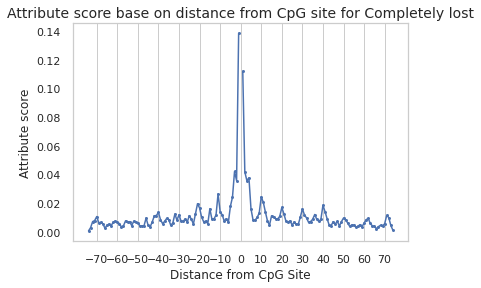

2020-08-03 12:01:46,750 [WARNING] No handles with labels found to put in legend.


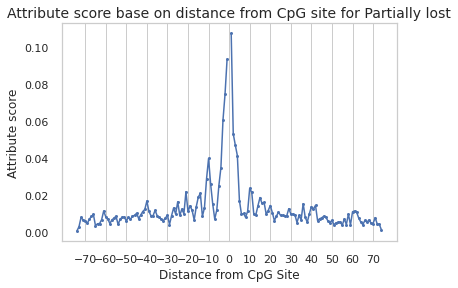

In [9]:
plot_distance_weight_two_sides(gradients_dictionary)

/gdrive/My Drive/nn/plotseqlogo.py:180: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


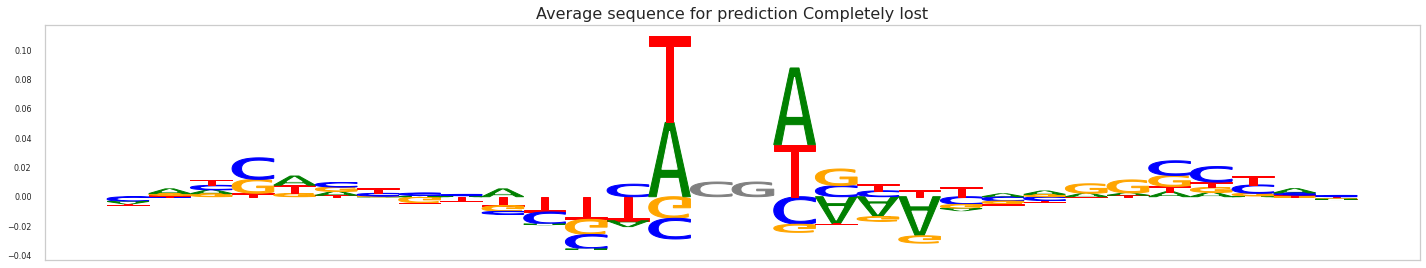

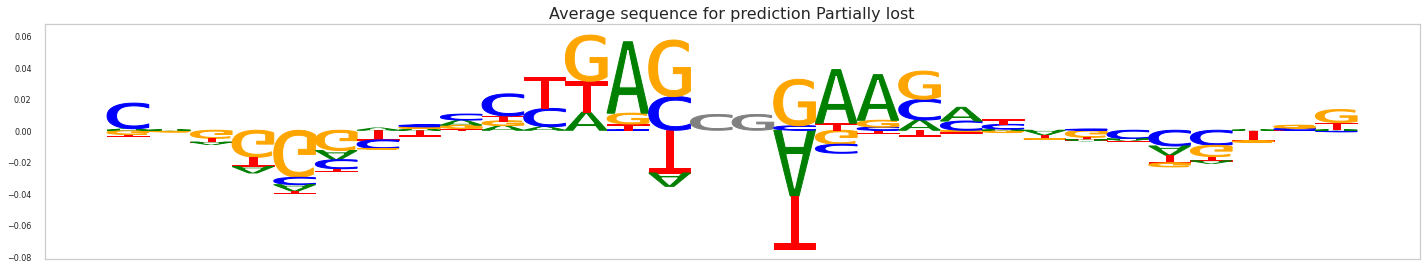

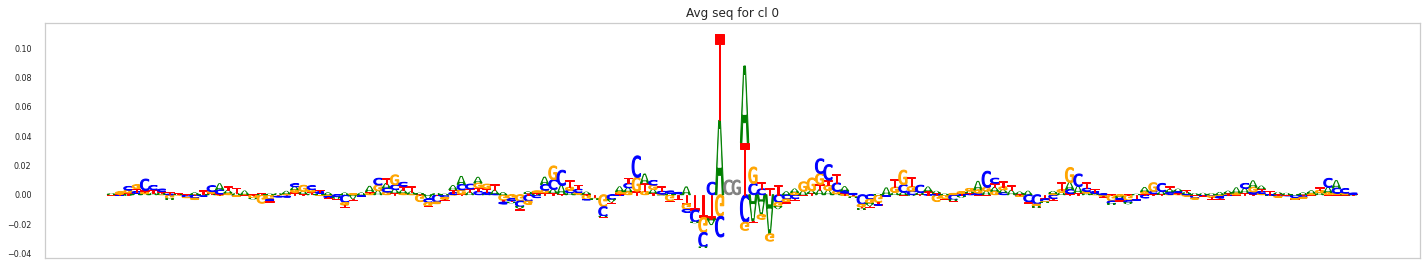

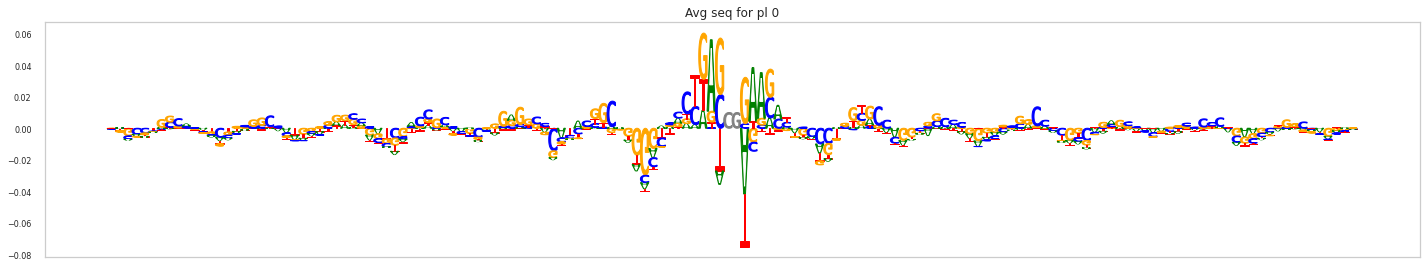

In [10]:
plot_avg_sequence(gradients_dictionary)

/gdrive/My Drive/nn/plotseqlogo.py:180: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


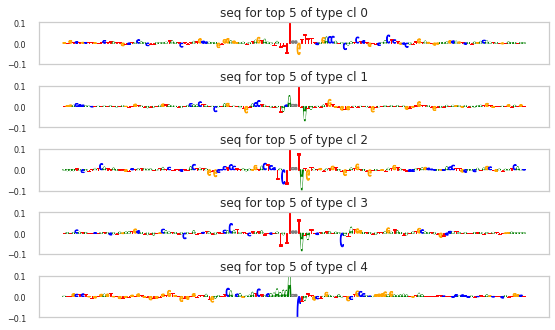

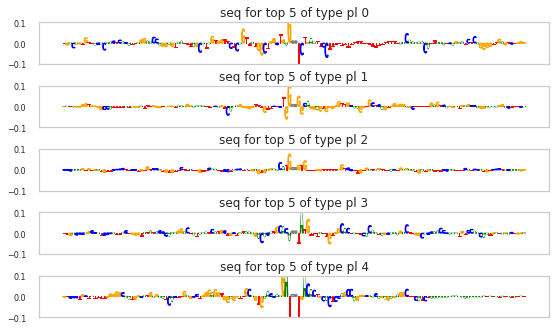

In [12]:
plot_multi_seq(gradients_dictionary, 5)